# iisgm-bioinfo-test

## Aptitude test for IiSGM Microbial Genomics candidates

In [1]:
import pandas as pd
import io
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from os import listdir
from os.path import isfile, join
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from matplotlib import pyplot as plt

###  Iteration 1 | Create a function to read a single VCF

In [2]:
def readVCF(file):
    with open(file, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
        df = pd.read_csv(io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t').rename(columns={'#CHROM': 'CHROM'})
    return df

### Iteration 2 | Extract relevant information from parsed VCF

M. tuberculosis in a haployd organism but those were called (variant calling step) as diploid, hence you will see the usual diploid genotyping (0/0, 0/1, 1/1).

With the correct information analysed, filter the SNPs actually present on each sample, this can be a different function.

Debido a que nuestro organismo es haploide, tenemos que eliminar los falsos positivos que salgan como heterocigóticos
Puesto que nunca va a haber heterocigosis. Para ello, nos tenemos que fijar en el formato PL, que expresa
la probabilidad en formato X,Y,Z siendo:
        X la probabilidad de que sea homocigótico para el alelo de referencia
        Y la probabilidad de que sea heterocigótico
        Z la probabilidad de que sea homocigótico para el alelo de referencia
Cuanto más bajo sean X, Y o Z, más probabilidad presentan.
Por ello, tenemos que eliminar todas las filas que tengan el número más bajo en la Y, que vienen representadas con
0/1 en el formato GT, que representa el genotipo.

In [3]:
def haploidise(vcf, samplename):
    i = vcf[vcf[samplename].str.startswith('0/1')].index
    x= vcf[vcf[samplename].str.startswith('1/2')].index
    for snp in range(0,len(i)):
        vcf=vcf.drop(i[snp])
    for snp in range(0, len(x)):
        vcf=vcf.drop(x[snp])
    vcf=vcf.reset_index(drop=True)
    return vcf

### Iteration 3 | Combine present SNP into a presence matrix + Iteration 5 | BONUS - Include INDELS

La función 'SNPs' recibe los archivos y los parsea uno a uno. Crea una lista con todas las posiciones en las que aparecen SNPs a largo de todos
los archivos; y crea un diccionario para cada muestra con el nombre de la posición y un 1 si aparece el SNP y un 0 si no. Además, añade un 2 si la variante de la posición corresponde a un indel.
Finalmente, la función 'matrix' crea la matriz de todos los archivos, añadiendo ceros en las posiciones donde no hay información para cada muestra.

In [4]:
def matrix(columns, rows, df):
    matrix=pd.DataFrame(df,columns=columns,index=[rows]).fillna(0).astype(int)
    return matrix

In [5]:
def SNPs(file):
    SampleNames=[]
    actualSNPs=[]
    positions=[]
    for f in file:
        #Se llama a las dos funciones y se appendea el nombre
        vcf =readVCF(f)
        SampleNames.append(vcf.columns[-1])

        lastColumn=str(vcf.columns[-1])

        vcf_filtered=haploidise(vcf,lastColumn)
    #Saco los datos en binario y los appendeo a una lista de listas donde cada lista es una muestra
        positions.extend(vcf_filtered['POS'].tolist())
        samplePositions=vcf_filtered['POS'].tolist()
        sampleSNPs={}
        for i in range(0,len(samplePositions)):
            if vcf_filtered.at[i,lastColumn].startswith('1/1') or vcf_filtered.at[i,lastColumn].startswith('1|1'):
                if len(vcf_filtered.at[i, 'REF']) or len(vcf_filtered.at[i, 'ALT']) != 0:
                    sampleSNPs[vcf_filtered.at[i,'POS']] = 2
                else:    
                    sampleSNPs[vcf_filtered.at[i,'POS']] = 1
            elif vcf_filtered.at[i,lastColumn].startswith('0/0') or vcf_filtered.at[i,lastColumn].startswith('0|0'):
                sampleSNPs[vcf_filtered.at[i,'POS']] = 0
            else:
                raise Exception('Genotype incorrect. Please make sure all your genotypes are labelled 1/1 or 0/0')
        actualSNPs.append(sampleSNPs)
    finalPositions=set(positions)
    finalPositions=sorted(finalPositions)
    
    matrixSNP=matrix(finalPositions, SampleNames, actualSNPs)

    return matrixSNP

### Iteration 4 | Calculate the SNP distance between all samples

In [6]:
def pairwise(file):
    matrix=SNPs(file)
    pairwise = pd.DataFrame(
        squareform(pdist(matrix)),
        columns = matrix.index,
        index = matrix.index
    )
    matrix.iloc[0:0]
    return pairwise

#### Leo todos los archivos del directorio, que corresponden a las muestras a analizar, y creo la matriz de distancias de todos ellos.

In [7]:
onlyfiles = [f for f in listdir('./') if isfile(join('./', f))]
onlyfiles.remove('iisgm-bioinfo-test-AnadelRamo.ipynb')
distance_matrix=pairwise(onlyfiles)
distance_matrix

,10082989-0-COL7,ALM10082989B3COL2018,10082989-0-COL2,AL10082989COL3,ALM93896B3COL6,ALM23685B3COL2,ALM93896B3COL12,ALM10105494B3COL3018,10105494-0-COL2,ALM23685B3COL6,...,10082989-0-COL14,ALM23685B3COL8,ALM93896B3COL3,ALM93896B3COL1,ALM93896B2COL31,10105494-0-COL40,ALM23685B3COL7,ALM10082989B3CO11R18,10082989-0-COL3,AL10105494COL0
10082989-0-COL7,0.000000,10.000000,4.898979,5.656854,8.000000,28.982753,13.711309,6.000000,4.000000,14.422205,...,7.483315,20.199010,6.928203,8.944272,8.944272,13.266499,12.961481,17.435596,10.954451,8.000000
ALM10082989B3COL2018,10.000000,0.000000,9.591663,9.165151,8.246211,27.784888,13.564660,9.380832,9.591663,13.711309,...,8.717798,19.078784,9.591663,10.770330,9.591663,12.806248,12.806248,16.613248,12.806248,11.489125
10082989-0-COL2,4.898979,9.591663,0.000000,5.656854,8.000000,28.705400,13.711309,5.291503,4.000000,14.142136,...,5.656854,19.595918,6.928203,8.944272,8.485281,12.961481,12.328828,17.204651,10.954451,8.485281
AL10082989COL3,5.656854,9.165151,5.656854,0.000000,7.483315,28.844410,13.416408,4.472136,4.898979,14.422205,...,6.324555,20.000000,6.928203,8.485281,8.485281,12.961481,12.328828,17.435596,11.313708,8.485281
ALM93896B3COL6,8.000000,8.246211,8.000000,7.483315,0.000000,28.284271,13.114877,7.745967,7.483315,14.142136,...,8.000000,19.595918,8.944272,8.485281,8.485281,12.000000,12.000000,16.492423,11.661904,10.198039
ALM23685B3COL2,28.982753,27.784888,28.705400,28.844410,28.284271,0.000000,27.640550,28.635642,28.982753,27.276363,...,28.284271,25.298221,28.284271,28.142495,27.856777,27.422618,27.568098,26.683328,27.712813,28.565714
ALM93896B3COL12,13.711309,13.564660,13.711309,13.416408,13.114877,27.640550,0.000000,12.961481,13.416408,15.874508,...,13.711309,19.899749,13.711309,13.416408,14.000000,15.362291,15.362291,18.867962,14.560220,14.000000
ALM10105494B3COL3018,6.000000,9.380832,5.291503,4.472136,7.745967,28.635642,12.961481,0.000000,5.291503,14.000000,...,5.291503,19.697716,7.211103,8.246211,8.246211,12.806248,11.832160,16.852300,11.135529,8.246211
10105494-0-COL2,4.000000,9.591663,4.000000,4.898979,7.483315,28.982753,13.416408,5.291503,0.000000,14.422205,...,6.324555,20.000000,6.324555,8.944272,8.485281,12.961481,12.328828,17.435596,10.954451,8.000000
ALM23685B3COL6,14.422205,13.711309,14.142136,14.422205,14.142136,27.276363,15.874508,14.000000,14.422205,0.000000,...,13.564660,19.183326,13.266499,14.422205,13.564660,14.696938,14.696938,17.888544,15.231546,15.491933


### Iteration 6 | BONUS - Represent distance in a phylogenetic tree

<ipython-input-8-a43ceb23d395>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward', optimal_ordering=True)


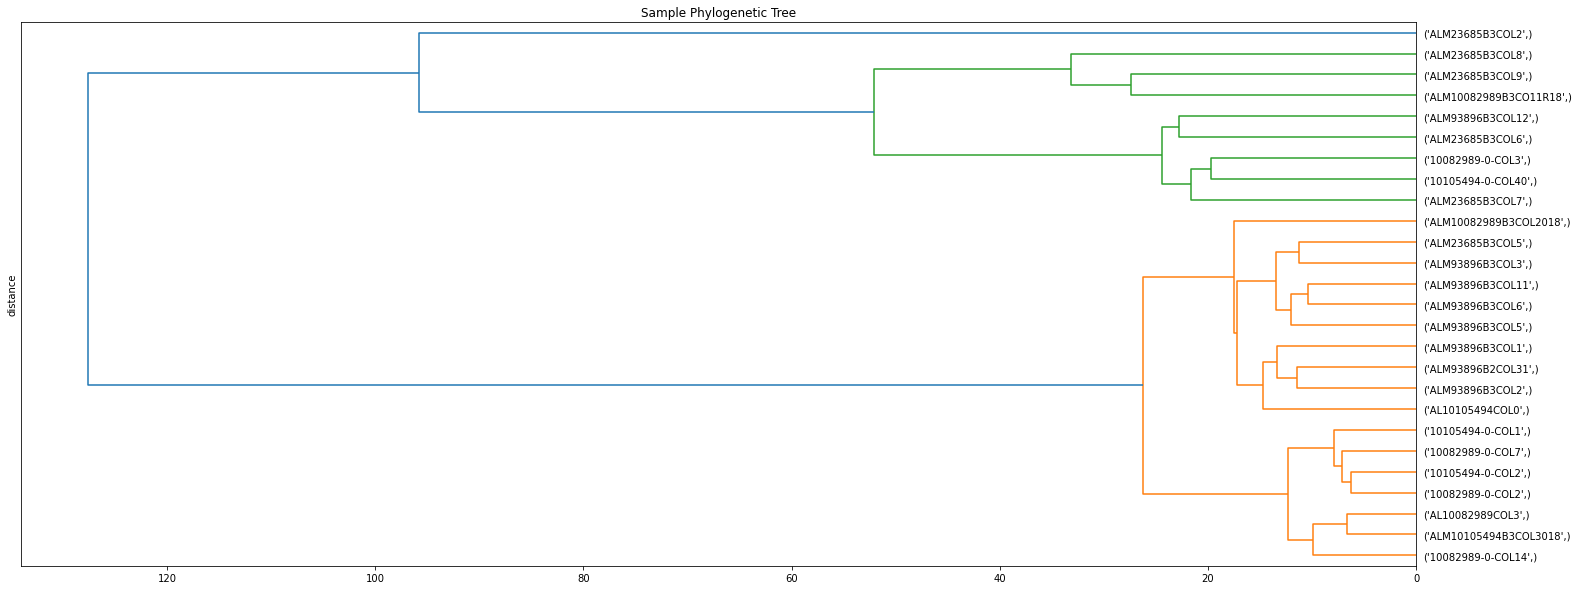

In [8]:
Z = linkage(distance_matrix, 'ward', optimal_ordering=True)
plt.figure(figsize=(25, 10))
plt.title('Sample Phylogenetic Tree')
plt.ylabel('distance')
dendrogram(Z,labels=distance_matrix.index.tolist(),get_leaves=False, orientation='left')
plt.show()